### **1. Import Dependencies**

In [1]:
import pandas as pd
import numpy as np

import gc
import os
import requests
import json
import re

import concurrent.futures
import asyncio
import httpx
import multiprocessing

from urllib.parse import urlencode

from typing import List, Dict, Optional, Union
from glob import glob

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, roc_auc_score

from sentence_transformers import SentenceTransformer
import fasttext
from gensim.models import KeyedVectors 

import tensorflow as tf
import tensorflow.keras as keras

from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input, Lambda, Dot, Layer
from keras.callbacks import EarlyStopping

import faiss

nltk.download('stopwords')
nltk.download('punkt')

d:\Programs\Miniconda3\envs\env_1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **2. Settings**

In [2]:
tf.random.set_seed(42)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### **3. Load Data**

In [3]:
def fetch_data(url: str, params=None):
  try:
    response = requests.get(url, params=params)
    if (response.status_code == 200):
      return response.json()
    
    print(f"Error response with status code: {response.status_code}")
  except Exception as error:
    print(f'Failed to fetch data: {error}')

def urls_builder(base_url: str, n_fetch: int, limit: int, products: List[str], **kwargs):
  urls = []
  for product in products:
    for i in range(n_fetch):
      
      param = {
        'offset': i * limit,
        'limit': limit,
        'product': product,
        **kwargs,
      }
      
      full_url = base_url + '?' + urlencode(param)
      urls.append(full_url)
    
  return urls

def save_json(data, path: str):
  with open(path, 'w') as json_file:
    json.dump(data, json_file)

def load_json(path: str):
  with open(path, 'r') as json_file:
    loaded_data = json.load(json_file)
  return loaded_data

In [4]:
# %%script skipped # Skipped due to resource optimization

selected_fields = ['id', 'duplicates', 'summary', 'description', 'status', 'resolution', 'platform', 'product', 'type', 'priority', 'severity', 'component']
products = ['Firefox']

base_params = {
  'include_fields': ', '.join(selected_fields),
  'type': 'defect',
}
saved_data_path = os.path.join('data_1', 'raw_data', 'firefox_raw_data.json')

base_url = 'https://bugzilla.mozilla.org/rest/bug'
n_fetch = 50
limit = 5000

if os.path.exists(saved_data_path):
  response_data = load_json(saved_data_path)
else:
  urls = urls_builder(base_url, n_fetch, limit, products, **base_params)
  response_data = []

  max_workers = 50
  with concurrent.futures.ThreadPoolExecutor(max_workers) as executor:
    response_data = list(executor.map(fetch_data, urls))
    
  response_data = [item['bugs'] for item in response_data]
  response_data = [item for sublist in response_data for item in sublist]
  
  save_json(response_data, saved_data_path)

In [24]:
raw_data_path = os.path.join('data_1', 'cache', 'raw_data.parquet')
df = pd.DataFrame()

if (os.path.exists(raw_data_path)):
  df = pd.read_parquet(raw_data_path)
else:
  data_paths = glob(os.path.join('data_1', 'raw_data', 'firefox_raw_data.json'))

  for path in data_paths:
    data = load_json(path)
    data = pd.DataFrame(data)
    df = pd.concat([df, data])

  df = df.set_index('id')
  df.to_parquet(raw_data_path)

df.head()

,severity,status,component,description,summary,platform,resolution,type,priority,duplicates,product
id,,,,,,,,,,,
14871,minor,RESOLVED,General,"Please add ""Match Whole Word Only"" option to b...",[Find] Find whole word only,All,DUPLICATE,defect,--,[],Firefox
24278,normal,RESOLVED,File Handling,I just tried to download a file with mozilla. ...,The download window is not resizable!,x86,WORKSFORME,defect,P3,[],Firefox
27493,S3,NEW,File Handling,"The choice of default directory, which the fil...",Default open/save directory isn't smart,All,,defect,P3,"[2226, 34974, 38526, 55478, 56782]",Firefox
35507,S3,NEW,File Handling,,URILoader needs to use webprogress to cancel l...,x86,,defect,--,[],Firefox
38121,S3,NEW,File Handling,Windows:\n1. Load http://www.w3.org/Style/CSS/...,"""save as"" should convert line breaks depending...",All,,defect,P4,"[40198, 89251, 109341, 146614, 147405, 211130]",Firefox


In [25]:
df = df.drop(['status', 'priority', 'resolution', 'severity', 'component', 'product', 'type'], axis=1)

gc.collect()

973

In [26]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 180361 entries, 14871 to 1877932
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  180361 non-null  object
 1   summary      180361 non-null  object
 2   platform     180361 non-null  object
 3   duplicates   180361 non-null  object
dtypes: object(4)
memory usage: 263.5 MB


### **3. EDA**

### **3.1. Missing Values**

In [27]:
df.isna().sum()

description    0
summary        0
platform       0
duplicates     0
dtype: int64

### **3.2. Product**

In [13]:
%%script skipped # Skipped

df['product'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.3. Platform**

In [28]:
df['platform'].value_counts(ascending=False)

platform
x86            80884
Unspecified    39764
All            28530
x86_64         19096
PowerPC         6273
Desktop         4625
Other            727
ARM              188
Sun              181
ARM64             51
HP                24
DEC                7
SGI                6
RISCV64            3
XScale             2
Name: count, dtype: int64

### **3.4. Type**

In [16]:
%%script skipped # Skipped

df['type'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.5. Duplicates**

In [29]:
duplicates = df['duplicates'].apply(lambda x: len(x)).sort_values(ascending=False)
duplicates

id
246078     114
247116      73
210910      69
69938       68
245392      66
          ... 
479529       0
479532       0
479534       0
479535       0
1877932      0
Name: duplicates, Length: 180361, dtype: int64

In [30]:
duplicated_bugs = duplicates[duplicates > 0]
duplicated_bugs.count()

12643

### **4. Feature Engineering**

### **4.1. Missing Values**

In [32]:
%%script skipped # Skipped

df.loc[df['type'] == '--', 'type'] = 'no type'

Couldn't find program: 'skipped'


### **4.2. Duplicates**

In [33]:
duplicated = df.loc[duplicated_bugs.index, 'duplicates']
duplicated

id
246078     [239385, 239561, 246164, 246674, 246958, 24697...
247116     [247032, 254990, 255342, 256792, 257710, 25950...
210910     [197227, 210933, 211542, 212349, 212382, 21269...
69938      [79637, 87494, 105392, 107129, 116505, 121880,...
245392     [245393, 245694, 246339, 246486, 247750, 24788...
                                 ...                        
424481                                              [430057]
680193                                              [772488]
1781903                                            [1743762]
315040                                              [335261]
442252                                              [442310]
Name: duplicates, Length: 12643, dtype: object

In [34]:
data_path = os.path.join('data_1', 'cache', 'duplicate_to_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['duplicates_to'] = -1

  for idx, dups in zip(duplicated.index, duplicated):
    for item in dups:
      df.loc[df.index == item, 'duplicates_to'] = idx
      
  df.to_parquet(data_path)

In [35]:
df = df.drop(columns=['duplicates'])

### **4.3. Clean Sentences**

In [36]:
def remove_special_chars(text: str):
  text = text.lower()
  text = re.sub(r'\n|\t|\r|\0', ' ', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  text = re.sub(r'\s$', '', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  
  return text

def remove_stopwords(text: str):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word not in stop_words]
  
  return ' '.join(filtered_words)

def clean_text(text: str):
  text = remove_special_chars(text)
  text = remove_stopwords(text)
  
  return text

df['platform'] = df['platform'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)

# df['type'] = df['type'].apply(clean_text)
# df['product'] = df['product'].apply(clean_text)

### **4.4. Combined Text**

In [37]:
df['text'] = df['platform'] + ' ' + df['summary'] + ' ' + df['description']

# df['text'] = df['type'] + ' ' + df['platform'] + ' ' + df['summary'] + ' ' + df['description']

In [38]:
df = df[['text', 'duplicates_to']]

df.head()

,text,duplicates_to
id,,
14871,find find whole word please add match whole w...,-1
24278,x86 download window resizable tried download f...,-1
27493,default open save directory smart choice defa...,-1
35507,x86 uriloader needs use webprogress cancel loads,-1
38121,save convert line breaks depending platform w...,-1


### **4.5. Sentence Embedding**

In [39]:
# %%script skipped # Skipped

sent_embd_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [41]:
# %%script skipped # Skipped

embd_data_path = os.path.join('data_1', 'cache', 'sent_trans_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sent_embd_model.encode)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

0

In [ ]:
# %%script skipped # Skipped

model_path = os.path.join('models', 'wiki-news-300d-1M-subword.vec')
sent_embd_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [39]:
# %%script skipped # Skipped

def sentence_embedding(sentence, model):
    words = word_tokenize(sentence)
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        return None

    embedding = np.mean([model[word] for word in words_in_vocab], axis=0)
    embedding = normalize(embedding.reshape(1, -1), norm='l2').reshape(-1)
    
    return embedding

In [112]:
# %%script skipped # Skipped

embd_data_path = os.path.join('data_1', 'cache', 'fasttext_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sentence_embedding, model=sent_embd_model)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

0

In [42]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 180361 entries, 14871 to 1877932
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           180361 non-null  object
 1   duplicates_to  180361 non-null  int64 
 2   text_embedded  180361 non-null  object
dtypes: int64(1), object(2)
memory usage: 452.8 MB


### **4.6. Sentence Pairs**

In [43]:
df = df.reset_index()

In [44]:
df_duplicates = df[df['duplicates_to'] != -1].copy()
df_uniques = df[df['duplicates_to'] == -1].copy()

In [45]:
df_duplicates = pd.merge(left=df_duplicates,
                        right=df_uniques,
                        left_on='duplicates_to',
                        right_on='id',
                        suffixes=('__left', '__right'))
df_duplicates = df_duplicates.drop(columns=['duplicates_to__left', 'duplicates_to__right'])
df_duplicates['label'] = 1
df_duplicates = df_duplicates.reset_index(drop=True)

df_duplicates.head()

,id__left,text__left,text_embedded__left,id__right,text__right,text_embedded__right,label
0,95091,x86 helper application lack mozilla 0 9 3 buil...,"[-0.05064879, -0.038834795, 0.0040822984, 0.03...",57420,support helper app command line args using m1...,"[0.03632154, -0.08749529, -0.07250358, -0.0945...",1
1,308815,x86 linux choose helper application allow user...,"[0.020580648, -0.03251207, -0.10909204, 0.0141...",57420,support helper app command line args using m1...,"[0.03632154, -0.08749529, -0.07250358, -0.0945...",1
2,406060,x86 nslocalhandlerapp fails hand uri correctly...,"[0.020628773, -0.048608445, 0.005101101, -0.06...",57420,support helper app command line args using m1...,"[0.03632154, -0.08749529, -0.07250358, -0.0945...",1
3,525506,x86 preferences applications use commandlines ...,"[0.007659245, -0.065760784, -0.077460386, -0.0...",57420,support helper app command line args using m1...,"[0.03632154, -0.08749529, -0.07250358, -0.0945...",1
4,134649,powerpc browser urlbar clickselectsall default...,"[-0.024015507, 0.012870593, 0.018699512, 0.129...",409810,powerpc clicking location bar selects whole ur...,"[-0.011166345, -0.04270263, 0.026916128, 0.060...",1


In [46]:
half_rows = df_uniques.shape[0] // 2
df_uniques = df_uniques.sample(frac=1, replace=False, random_state=42)

df_uniques_temp = pd.DataFrame()
df_uniques_temp['text_embedded__left'] = df_uniques['text_embedded']
df_uniques_temp['text__left'] = df_uniques['text']
df_uniques_temp['id__left'] = df_uniques['id']

df_uniques_temp['text_embedded__right'] = df_uniques['text_embedded'].shift(1)
df_uniques_temp['text__right'] = df_uniques['text'].shift(1)
df_uniques_temp['id__right'] = df_uniques['id'].shift(1)

df_uniques_temp = df_uniques_temp.dropna()
df_uniques_temp['label'] = 0

df_uniques = df_uniques_temp.reset_index(drop=True)

del df_uniques_temp
gc.collect()

df_uniques.head()

,text_embedded__left,text__left,id__left,text_embedded__right,text__right,id__right,label
0,"[0.049917005, -0.03702191, -0.077136844, 0.018...",x86 view text size normal ctrl 0 work keypad z...,262896,"[-0.061627317, -0.05548735, 0.016275661, -0.02...",unspecified send tabs getting fxai currentacco...,1582542.0,0
1,"[-0.008961278, 0.05875989, -0.04428572, 0.0341...",x86 64 horrible rendering text ff19 0 user age...,847091,"[0.049917005, -0.03702191, -0.077136844, 0.018...",x86 view text size normal ctrl 0 work keypad z...,262896.0,0
2,"[0.021460924, -0.052563563, 0.012884889, 0.057...",unspecified remote settings fetching broken as...,1780445,"[-0.008961278, 0.05875989, -0.04428572, 0.0341...",x86 64 horrible rendering text ff19 0 user age...,847091.0,0
3,"[-0.014556644, -0.03459076, 0.06754639, -0.002...",x86 64 pressing current url search url empty s...,1540710,"[0.021460924, -0.052563563, 0.012884889, 0.057...",unspecified remote settings fetching broken as...,1780445.0,0
4,"[0.01124776, -0.0707667, 0.019575356, 0.032355...",x86 undo close tab replaces single blank tab u...,720670,"[-0.014556644, -0.03459076, 0.06754639, -0.002...",x86 64 pressing current url search url empty s...,1540710.0,0


In [47]:
df = pd.concat([df_duplicates, df_uniques], axis=0).sample(frac=1, replace=False, random_state=42).reset_index(drop=True)
gc.collect()

0

### **5. Data Split**

### **5.1. Train Test Split**

In [48]:
X, X_test, y, y_test = train_test_split(df[['text_embedded__left', 'text_embedded__right']],
                                                    df['label'],
                                                    shuffle=True,
                                                    stratify=df['label'],
                                                    test_size=0.3,
                                                    random_state=42)

print(f'Shape of X_train: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (125531, 2)
Shape of X_test: (53800, 2)
Shape of y_train: (125531,)
Shape of y_test: (53800,)


### **5.2. Data Fold**

In [49]:
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **6. Model Preparation**

In [50]:
input_1 = Input(shape=(384, ), name='input_1')
input_2 = Input(shape=(384, ), name='input_2')

shared_node_1 = Dense(256, name='shared_node_1')
shared_node_2 = Dense(256, name='shared_node_2')
shared_node_3 = Dense(128, name='shared_node_3')
shared_node_4 = Dense(128, name='shared_node_4')

x1 = shared_node_1(input_1)
x1 = shared_node_2(x1)
x1 = shared_node_3(x1)
x1 = shared_node_4(x1)

x2 = shared_node_1(input_2)
x2 = shared_node_2(x2)
x2 = shared_node_3(x2)
x2 = shared_node_4(x2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)

training_model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

training_model.summary()


Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 shared_node_1 (Dense)       (None, 256)                  98560     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 shared_node_2 (Dense)       (None, 256)                  65792     ['shared_node_1[

### **7. Model Training**

### **7.1. Traning Preparation**

In [51]:
tf.random.set_seed(42)
gc.collect()

405

In [52]:
def train_model(X_train, X_valid, y_train, y_valid, batch_size, epochs, callbacks=None, verbose='auto'):
  training_model.fit(X_train,
                       y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_valid, y_valid),
                       callbacks=[*callbacks],
                       verbose=verbose)
    
  train_score = training_model.evaluate(X_train, y_train, verbose=verbose)[1:]
  valid_score = training_model.evaluate(X_valid, y_valid, verbose=verbose)[1:]
  
  return (train_score, valid_score)

### **7.2. Model Training**

In [882]:
epochs = 10
batch_size = 32

train_scores = []
valid_scores = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train_inputs = [np.vstack(X_train['text_embedded__left']), np.vstack(X_train['text_embedded__right'])]
    X_valid_inputs = [np.vstack(X_valid['text_embedded__left']), np.vstack(X_valid['text_embedded__right'])]
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    train_score, valid_score = train_model(X_train_inputs,
                                           X_valid_inputs,
                                           y_train,
                                           y_valid,
                                           batch_size=batch_size,
                                           epochs=epochs,
                                           callbacks=[early_stopping],
                                           verbose=0)
    
    print(f'fold-{fold + 1}: train - precision = {train_score[0]}, recall = {train_score[1]}')
    print(f'fold-{fold + 1}: valid - precision = {valid_score[0]}, recall = {valid_score[1]}')
    print('-' * 200)
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    
train_scores_avg = np.mean(train_scores, axis=0)
valid_scores_avg = np.mean(train_scores, axis=0)

print(f'average_score: train - precision = {train_scores_avg[0]}, recall = {train_scores_avg[1]}')
print(f'average_score: valid - precision = {valid_scores_avg[0]}, recall = {valid_scores_avg[1]}')

fold-1: train - precision = 0.9321084022521973, recall = 0.9087702035903931
fold-1: valid - precision = 0.8746867179870605, recall = 0.8691200613975525
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold-2: train - precision = 0.9238320589065552, recall = 0.9177618026733398
fold-2: valid - precision = 0.8732782602310181, recall = 0.877144455909729
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold-3: train - precision = 0.9380005598068237, recall = 0.9073113203048706
fold-3: valid - precision = 0.8902438879013062, recall = 0.8683264255523682
-----------------------------------------------------------------------------------------------------------------------------------------------

### **7.3. Save/Load Model**

In [81]:
saved_model_path = os.path.join('models', 'model.pkl')
# joblib.dump(training_model, saved_model_path)

training_model = joblib.load(saved_model_path)

### **7.4. Model Evaluation**

In [900]:
val_predictions = training_model.predict([np.vstack(X_test['text_embedded__left']), np.vstack(X_test['text_embedded__right'])])
val_predictions_binary = (val_predictions > 0.5).astype(int)

precision = precision_score(y_test, val_predictions_binary)
recall = recall_score(y_test, val_predictions_binary)
auc = roc_auc_score(y_test, val_predictions_binary)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')

1961/1961 [==============================] - 3s 2ms/step
Precision: 0.8672
Recall: 0.8492
AUC: 0.9154


### **7.5. Embedding Model Preparation**

In [82]:
embd_input = Input(shape=(384, ), name='input')
embd_hidden = training_model.get_layer('shared_node_1')(embd_input)
embd_hidden = training_model.get_layer('shared_node_2')(embd_hidden)
embd_hidden = training_model.get_layer('shared_node_3')(embd_hidden)
embd_output = training_model.get_layer('shared_node_4')(embd_hidden)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Model: "embd_inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384)]             0         
                                                                 
 shared_node_1 (Dense)       (None, 256)               98560     
                                                                 
 shared_node_2 (Dense)       (None, 256)               65792     
                                                                 
 shared_node_3 (Dense)       (None, 128)               32896     
                                                                 
 shared_node_4 (Dense)       (None, 128)               16512     
                                                                 
Total params: 213760 (835.00 KB)
Trainable params: 213760 (835.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7.6. Embedding Model Evaluation**

In [83]:
def custom_cosine_similarity(text_1: np.ndarray, text_2: np.ndarray):
    dot_product = np.dot(text_1, text_2)
    norm_text_1 = np.linalg.norm(text_1)
    norm_text_2 = np.linalg.norm(text_2)
    
    similarity = dot_product / (norm_text_1 * norm_text_2)
    
    return similarity

In [84]:
embd_test_left = embd_model.predict(np.vstack(X_test['text_embedded__left']))
embd_test_right = embd_model.predict(np.vstack(X_test['text_embedded__right']))
embd_similarity = np.array([custom_cosine_similarity(embd_1, embd_2) for embd_1, embd_2 in zip(embd_test_left, embd_test_right)])

1961/1961 [==============================] - 2s 1ms/step


In [87]:
def evaluate_model(similarity_scores: np.ndarray, threshold: float):
  embd_binary_similarity = (similarity_scores > threshold).astype(int)

  precision = precision_score(y_test, embd_binary_similarity)
  recall = recall_score(y_test, embd_binary_similarity)
  auc = roc_auc_score(y_test, embd_binary_similarity)
  
  return [precision, recall, auc]

In [908]:
threshold_eval = pd.DataFrame([[threshold, *evaluate_model(embd_similarity, threshold)] for threshold in np.linspace(0, 1, 1000)], columns=['threshold', 'precision', 'recall', 'auc'])
threshold_eval.sort_values(by='auc', ascending=False)

,threshold,precision,recall,auc
501,0.501502,0.711361,0.932989,0.939836
500,0.500501,0.709741,0.933247,0.939747
498,0.498498,0.706267,0.934151,0.939717
488,0.488488,0.692000,0.938154,0.939673
502,0.502503,0.713382,0.931956,0.939611
...,...,...,...,...
995,0.995996,1.000000,0.025178,0.512589
996,0.996997,1.000000,0.024661,0.512331
997,0.997998,1.000000,0.023370,0.511685
998,0.998999,1.000000,0.022853,0.511427


<Axes: title={'center': 'Metrics Evaluation'}, xlabel='Threshold', ylabel='Metric score'>

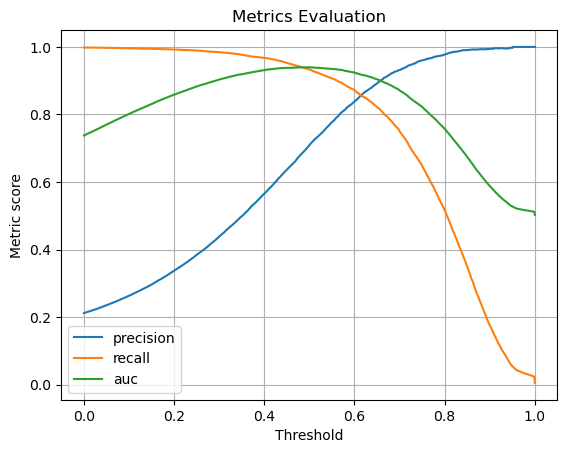

In [909]:
threshold_eval.plot(kind='line',
                    title='Metrics Evaluation',
                    x='threshold',
                    xlabel='Threshold',
                    ylabel='Metric score',
                    grid=True)

In [88]:
model_eval = evaluate_model(embd_similarity, 0.84)

print(f'Precision: {model_eval[0]:.5f}')
print(f'Recall: {model_eval[1]:.5f}')
print(f'AUC: {model_eval[2]:.5f}')

Precision: 0.99034
Recall: 0.38399
AUC: 0.69173


In [93]:
df_embd = df[['text__left', 'text_embedded__left']].rename(columns={'text__left': 'text', 'text_embedded__left': 'text_embedded'}).copy()
df_embd['text_embedded'] = embd_model.predict(np.vstack(df_embd['text_embedded'])).tolist()

df_embd.head()

6536/6536 [==============================] - 8s 1ms/step


,text,text_embedded
0,defect x86 64 timeline new tab page content lo...,"[-1442.97509765625, -309.9499206542969, 549.81..."
1,defect x86 64 users told refresh firefox witho...,"[-1142.993408203125, 1058.1937255859375, -528...."
2,defect unspecified failure browser components ...,"[-906.2084350585938, -2149.55615234375, 1594.4..."
3,defect x86 fix identity icon label padding lin...,"[-228.60427856445312, 53.46491241455078, -1029..."
4,defect x86 prishtinanet com causes firefox cra...,"[893.91455078125, 1100.9400634765625, -503.231..."


<Axes: >

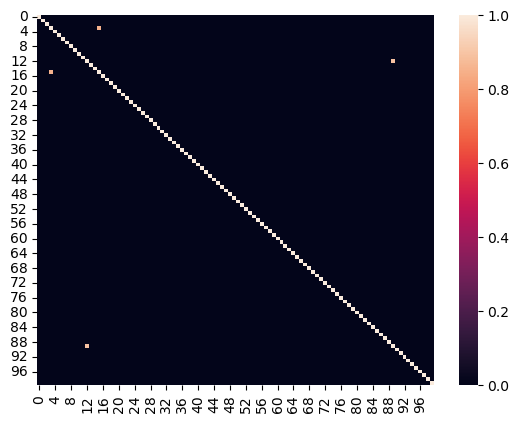

In [114]:
corr = cosine_similarity(np.vstack(df_embd['text_embedded'][:100]), np.vstack(df_embd['text_embedded'][:100]))
corr = np.where(corr >= 0.84, corr, 0)

sns.heatmap(corr)

In [115]:
data_1 = df_embd.iloc[3]
data_2 = df_embd.iloc[15]

print(data_1['text'])
print(data_2['text'])

print(cosine_similarity([data_1['text_embedded']], [data_2['text_embedded']]))

defect x86 fix identity icon label padding linux bug 406612 landed created linux ts regression attributable browser css changes patch two rules removed one involving sizing identity icon label font calculations expensive one hiding label value empty remove dangling padding font sizing stay far concerned likely culprit land text hiding patch attached code reviewed gavin bug 406612 think needs reviewed need approval blocking status land since tree closed beta3 low priority easy bit polish
enhancement  explicitly make activist balanced dreamer balanced light themes automatic color scheme detection considers activist balanced dreamer balanced dark themes want light like balanced colorways difference apparent toggling balanced colorways colorway closet adopts color scheme instantly
[[0.85479224]]


In [117]:
import numpy as np
import faiss

# Example data (replace this with your actual embedded sentences)
embedded_sentences = np.random.rand(1000, 384).astype(np.float32)

# Initialize the Faiss index
index = faiss.IndexFlatL2(384)  # L2 distance index for Euclidean distance

# Add embedded sentences to the index
index.add(embedded_sentences)

# Query for similar vectors to a given query vector
query_vector = np.random.rand(384).astype(np.float32)  # Replace with your actual query vector
k = 5  # Number of nearest neighbors to retrieve

# Perform the similarity search
distances, indices = index.search(query_vector.reshape(1, -1), k)

# Display the results
print("Query Vector:")
print(query_vector)
print("\nNearest Neighbors:")
print(embedded_sentences[indices[0]])
print("\nDistances:")
print(distances[0])

Query Vector:
[0.87860686 0.22653875 0.65734774 0.96605545 0.15145151 0.2982492
 0.5165359  0.28707543 0.9061593  0.36739534 0.34405288 0.05615452
 0.751676   0.42787138 0.11478934 0.5781669  0.21105713 0.49473268
 0.8429029  0.17072904 0.08898357 0.62752676 0.52478963 0.05872801
 0.1791995  0.19407521 0.04045861 0.09941993 0.4479414  0.00552192
 0.02916618 0.83127666 0.21180315 0.85808176 0.19852638 0.7432397
 0.39331847 0.8940792  0.22746792 0.22474612 0.13187602 0.44633147
 0.7892145  0.97325355 0.41099414 0.19369474 0.74277127 0.07681527
 0.6246317  0.24130125 0.48736638 0.39253554 0.9999381  0.7563497
 0.08966024 0.7217545  0.6162019  0.5653666  0.76087123 0.81508005
 0.5632371  0.6939933  0.6367015  0.9300481  0.41462302 0.52910763
 0.3421057  0.99765795 0.5737631  0.895744   0.0121693  0.7435259
 0.26196012 0.8332001  0.2419089  0.7525511  0.12653184 0.6506273
 0.92564946 0.21787514 0.68620205 0.22175765 0.56336695 0.81550634
 0.5254116  0.08332592 0.27293006 0.8734649  0.79145 